# Exploratory Data Analysis

Breast cancer is one of the most common types of cancer, and early detection is crucial in its treatment. It develops from breast tissue when cells in the region grow out of control. One of the key steps in treating breast cancer is  accurate diagnosis.
We want to predict whether the cancer is benign or malignant, here we start by understand the dataset.

# Import libraries:

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
# from scripts.dataframe_cleaner import DfCleaner
# from scripts.log import App_Logger
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("../data/data.csv")

# About the dataset:
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Columns represent:
#### 1. ID number
#### 2. Diagnosis (M = malignant, B = benign) 
#### 3-32 
#### Ten real-valued features are computed for each cell nucleus:
#### a. radius (mean of distances from center to points on the perimeter)
#### b. texture (standard deviation of gray-scale values)
#### c. perimeter 
#### d) area 
#### e) smoothness (local variation in radius lengths)
#### f. compactness (perimeter^2 / area - 1.0)
#### g. concavity (severity of concave portions of the contour)
#### h. concave points (number of concave portions of the contour)
#### i. symmetry 
#### j) fractal dimension ("coastline approximation" - 1)
The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

In [2]:
data.shape

(569, 33)

We have 33 columns with 569 records!

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
print('unique column values')
data.apply(lambda x: len(x.unique())).sort_values(ascending=False)

unique column values


id                         569
smoothness_se              547
fractal_dimension_se       545
area_worst                 544
concave points_mean        542
compactness_se             541
radius_se                  540
area_mean                  539
concavity_worst            539
compactness_mean           537
concavity_mean             537
fractal_dimension_worst    535
perimeter_se               533
concavity_se               533
compactness_worst          529
area_se                    528
perimeter_mean             522
texture_se                 519
perimeter_worst            514
texture_worst              511
concave points_se          507
symmetry_worst             500
fractal_dimension_mean     499
symmetry_se                498
concave points_worst       492
texture_mean               479
smoothness_mean            474
radius_worst               457
radius_mean                456
symmetry_mean              432
smoothness_worst           411
diagnosis                    2
Unnamed:

All of records from Id column are unique values, diagnosis has only 2 unique values which are malignant and benign. Now let's check if there is a missing values

In [5]:
missing_values = data.isnull().sum()
missing_values

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

That's perfect! There isn't null values, except for the last column which is Unnamed and we can conclude it's unnecessary column!
Now let's exclude unnecessary columns from the dataset and separate it to dependent(y) and an independent(X) data:
*  <b>Id cannot be used for classification.</b>
*  <b>Diagnosis is our class label.</b>
*  <b>Unnamed column.</b>

In [6]:
# y includes our outcome label and X includes our features
y = data.diagnosis # M or B 
list_drop = ['Unnamed: 32','id','diagnosis']
X = data.drop(list_drop,axis = 1 )
X.shape

(569, 30)

In [7]:
# Let's check if there is duplicates
dups = X.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(X[dups])

False
Empty DataFrame
Columns: [radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst]
Index: []

[0 rows x 30 columns]


Findings:
<ul>
    <li>There are <b>569</b> instances of <b>data</b>.</li>
    <li>Total number of <b>features</b> equals <b>33</b>, of which <b>31 is numerical, </b> plus <b>Id</b> and <b>diagnosis.</b></li>
    <li>One <b>feature (Unnamed: 32)</b> has missing values in the dataset</li>
    <li> There is one unique column which is <b>'Id'</b></li>
    <li> No <b>duplicate</b> records</li>
 </ul>

Statistical overview

In [8]:
X.describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean  ...  radius_worst  \
count     569.000000              569.000000  ...    569.000000   
mean        0.181162                0.062798  ...     16.269190   
std         0.027414                0.007060  ...      4.833242   
min         0.106000                0.049960  ...      7.930000   
25%         0.161900                0.057700  ...     13.010000   
50%         0.179200                0.061540  ...     14.970000   
75%         0.195700                0.066120  ...     18.790000   
max         0.304000                0.097440  ...     36.040000   

       texture_worst  perimeter_worst   area_worst  smoothness_worst  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000          0.222600   

       compactness_worst  concavity_worst  concave points_worst  \
count         569.000000       569.000000            569.000000   
mean            0.254265         0.272188              0.114606   
std             0.157336         0.208624              0.065732   
min             0.027290         0.000000              0.000000   
25%             0.147200         0.114500              0.064930   
50%             0.211900         0.226700              0.099930   
75%             0.339100         0.382900              0.161400   
max             1.058000         1.252000              0.291000   

       symmetry_worst  fractal_dimension_worst  
count      569.000000               569.000000  
mean         0.290076                 0.083946  
std          0.061867                 0.018061  
min          0.156500                 0.055040  
25%          0.250400                 0.071460  
50%          0.282200                 0.080040  
75%          0.317900                 0.092080  
max          0.663800                 0.207500  

[8 rows x 30 columns]

In [9]:
X.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Number of Benign:  357
Number of Malignant :  212


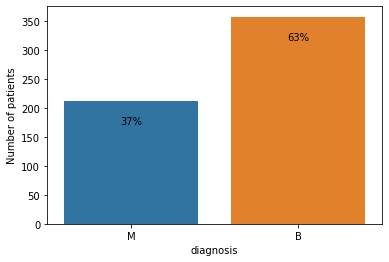

In [10]:
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)
ax.set_ylabel('Number of patients')
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]
for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r
    ax.text(left.get_x() + left.get_width()/2., height_l - 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r - 40 , '{0:.0%}'.format(height_r/total), ha="center")

We can conclude that:
* Important summary statistics of all the numerical variables like the mean, std, min, 25%, 50%, 75%, and max values.
* There is <b>high variation</b> in values in <b>area_mean</b> and <b>area_worst.
* There are many variables have median value 0.
* The <b>area_worst</b> feature’s max value is <b>4254</b> and <b>fractal_dimension_se</b> features’ max <b>0.029840</b>. This indicates we need to standardize or normalize data before visualization, feature selection, and classification.
* <b>Bar plot</b> of <b>diagnosis</b> shows that <b>Malignant</b> and <b>Benign</b> patients ratio is <b>37% (212/569)</b> and <b>63% (357/569)</b> respectively. 

Now to check whether the <b>numerical features</b> follow a <b>normal distribution</b> or <b>not</b>, we applied test called <b>Shapiro–Wilk test</b> 

In [11]:
# Check normal distribution of all numerical features
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(X)
normal = normal.apply(test_normality)
print(not normal.any())

False


This means none of the numerical features follow the normal distribution.

A violinplot is a graphical representation of data where values are depicted by color. A violin plot pursues the same activity that a whisker or box plot does.

Before plotting our data we need to normalization or standardization. Because differences between values of features are very high to observe on plot. We plot features in two groups and each group includes 15 features to observe better.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean'),
  Text(10, 0, 'radius_se'),
  Text(11, 0, 'texture_se'),
  Text(12, 0, 'perimeter_se'),
  Text(13, 0, 'area_se'),
  Text(14, 0, 'smoothness_se')])

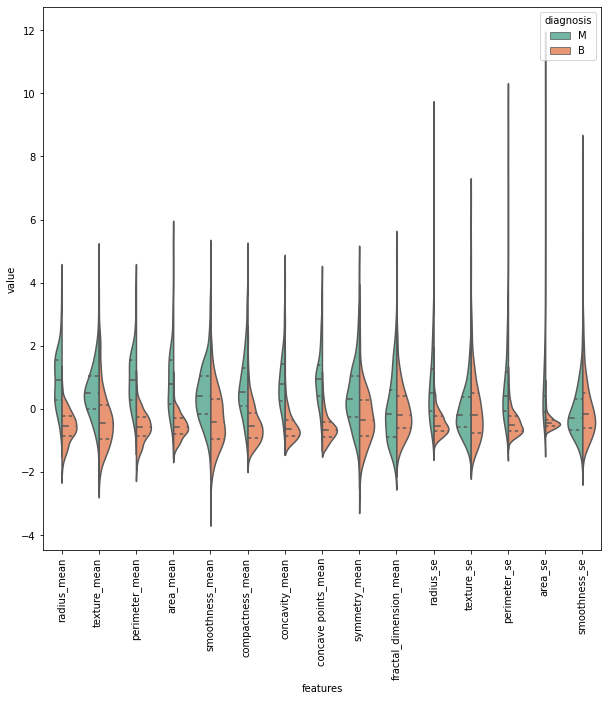

In [12]:
# First 15 features
data_dia = y
data = X
# standardization of the data
data_n_2 = (data - data.mean()) / (data.std())
data = pd.concat([y,data_n_2.iloc[:,0:15]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data, split=True, inner="quart", palette ="Set2")
plt.xticks(rotation=90)

Lets interpret the plot above together. Green represents Malignant cases and orange Benign. For example, in <b>radius_mean,texture_mean,perimeter_mean, area_mean, compactness_mean, concavity_mean and concave_points_mean</b> features, median of the Malignant and Benign looks like separated so it can be good for classification. However, in <b>fractal_dimension_mean, texture_se, and smoothness_se features</b>, median of the Malignant and Benign does not looks like separated so it does not gives good information for classification.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'compactness_se'),
  Text(1, 0, 'concavity_se'),
  Text(2, 0, 'concave points_se'),
  Text(3, 0, 'symmetry_se'),
  Text(4, 0, 'fractal_dimension_se'),
  Text(5, 0, 'radius_worst'),
  Text(6, 0, 'texture_worst'),
  Text(7, 0, 'perimeter_worst'),
  Text(8, 0, 'area_worst'),
  Text(9, 0, 'smoothness_worst'),
  Text(10, 0, 'compactness_worst'),
  Text(11, 0, 'concavity_worst'),
  Text(12, 0, 'concave points_worst'),
  Text(13, 0, 'symmetry_worst'),
  Text(14, 0, 'fractal_dimension_worst')])

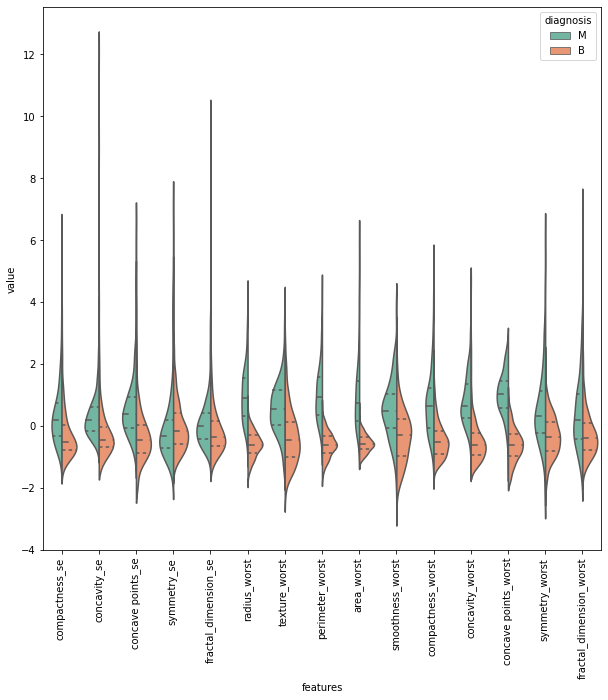

In [13]:
# Next 15 features
data = pd.concat([y,data_n_2.iloc[:,15:30]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart",palette ="Set2")
plt.xticks(rotation=90)

Lets interpret one more thing about plots above, variable of <b>texture_se, smoothness_se, concavity_worst, and concave point_worst looks like similar</b> but how can we decide whether they are correlated with each other or not. (Not always true but, basically if the features are correlated with each other we can drop one of them)

A swarm plot is very similar to a strip plot. It is basically a scatter plot where the x axis represents a categorical variable. Typical uses of a strip plot involves applying a small random jitter value to each data point such that the separation between points becomes clearer:

Before plotting our data we need to normalization or standardization. Because differences between values of features are very high to observe on plot. I plot features in two groups and each group includes 15 features to observe better.

<b>Swarm plot for first 15 features (1-15).</b>

c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 69.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 70.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 70.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 73.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, U

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean'),
  Text(10, 0, 'radius_se'),
  Text(11, 0, 'texture_se'),
  Text(12, 0, 'perimeter_se'),
  Text(13, 0, 'area_se'),
  Text(14, 0, 'smoothness_se')])

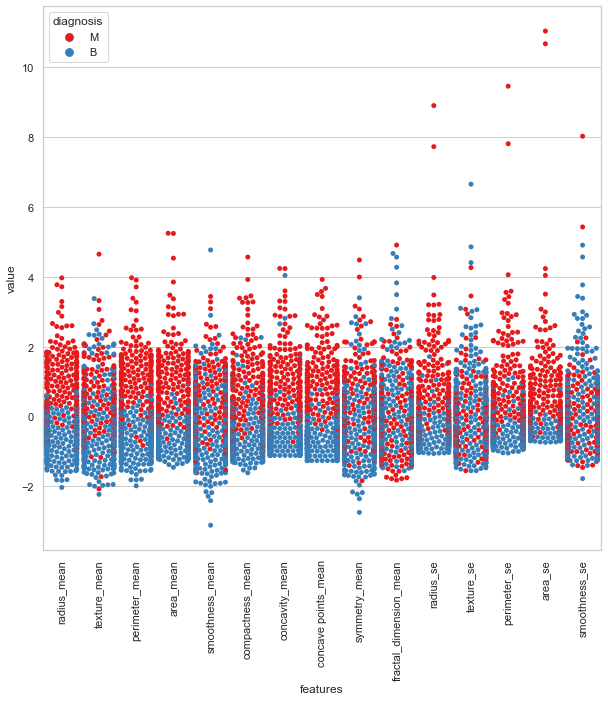

In [14]:
# First 15 features
sns.set(style="whitegrid", palette="Set1")
data_dia = y
data = X
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,0:15]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
#tic = time.time()
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=90)

Each dot represents a cancer patients. Red indicates Malignant and blue Benign pateints. They looks cool right and we can see variance more clear. Let me ask you a question, in these two plots which feature looks like more clear in terms of classification. In my opinion <b>radius_mean, area_se</b> in the above swarm plot looks like malignant and benign are separated not totally but mostly. However, <b>smoothness_mean,symmetry_mean, fractal_dimension_mean, and texture_mean</b> in the above swarm plot looks like malignant and benign are mixed so it is hard to classify while using these feature.

c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 74.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 78.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 72.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, U

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'compactness_se'),
  Text(1, 0, 'concavity_se'),
  Text(2, 0, 'concave points_se'),
  Text(3, 0, 'symmetry_se'),
  Text(4, 0, 'fractal_dimension_se'),
  Text(5, 0, 'radius_worst'),
  Text(6, 0, 'texture_worst'),
  Text(7, 0, 'perimeter_worst'),
  Text(8, 0, 'area_worst'),
  Text(9, 0, 'smoothness_worst'),
  Text(10, 0, 'compactness_worst'),
  Text(11, 0, 'concavity_worst'),
  Text(12, 0, 'concave points_worst'),
  Text(13, 0, 'symmetry_worst'),
  Text(14, 0, 'fractal_dimension_worst')])

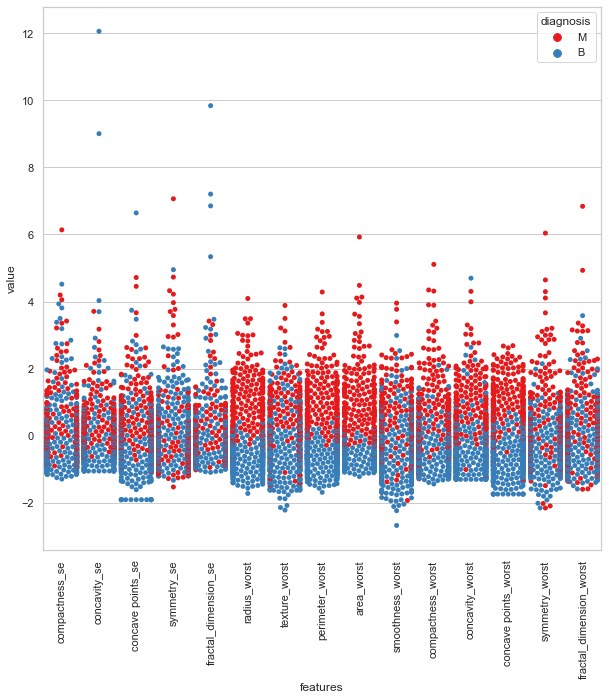

In [15]:
# Next 15 features
data = pd.concat([y,data_n_2.iloc[:,15:30]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=90)

Smilarly, in my opinion <b>radius_worst, area_worst</b> in the above swarm plot looks like malignant and benign are separated not totally but mostly. However, <b>compactness_se,symmetry_se, and smoothness_worst</b> in the above swarm plot looks like malignant and benign are mixed so it is hard to classify while using these feature.

We can conclude that:
* <b>None</b> of the continuous feature follows normal distribution. 
* vialinplot and swarmplot can be used to see the distribution of cases.
* We can interprete from violin plot, features <b>radius_mean,texture_mean,perimeter_mean, area_mean, compactness_mean, concavity_mean, and concave_points_mean</b> may be good for cancer classification.
* Pair of variables of <b>(concavity_worst, and concave point_worst), (concavity_mean and concave point_mean), and (concavity_se and concave point_se)</b> looks like similar. Check correlation between them. 
* Swarm plot indicates variables <b>radius_mean, area_se, radius_worst, and area_worst</b> looks like malignant and benign are separated not totally but mostly.

Check both the distribution and relationship between two variables. From above information from violin and swarm plot, lets check the correlation between similar variables. 

<b>Check correlation between concavity_worst and concave point_worst using joint plot.</b>


c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.1, 0.9, '$\\rho = 0.855, p = 0.000$')

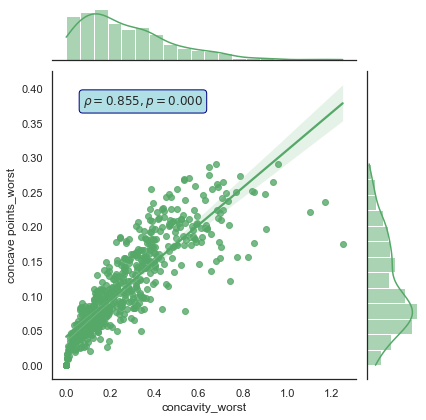

In [16]:
import scipy.stats as stats
sns.set(style="white",color_codes=True)
jp=sns.jointplot(X.loc[:,'concavity_worst'], X.loc[:,'concave points_worst'], kind="reg",color="g")

#jp.annotate(stats.pearsonr(X.loc[:,'concavity_worst'], X.loc[:,'concave points_worst']))
r, p = stats.pearsonr(X.loc[:,'concavity_worst'], X.loc[:,'concave points_worst'])
jp.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

<b>Check correlation between concavity_mean and concave point_mean using joint plot.</b>

c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.1, 0.9, '$\\rho = 0.921, p = 0.000$')

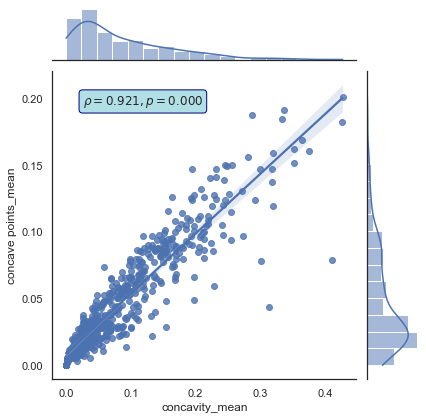

In [17]:
jp=sns.jointplot(X.loc[:,'concavity_mean'], X.loc[:,'concave points_mean'], kind="reg",color="b")
#jp.annotate(stats.pearsonr)
r, p = stats.pearsonr(X.loc[:,'concavity_mean'], X.loc[:,'concave points_mean'])
jp.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

<b>Check correlation between concavity_se and concave point_se using joint plot.</b>

c:\users\rafaa\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.1, 0.9, '$\\rho = 0.772, p = 0.000$')

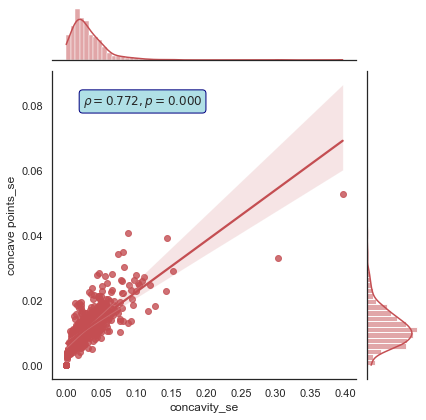

In [18]:
jp=sns.jointplot(X.loc[:,'concavity_se'], X.loc[:,'concave points_se'], kind="reg",color="r")
#jp.annotate(stats.pearsonr)
r, p = stats.pearsonr(X.loc[:,'concavity_se'], X.loc[:,'concave points_se'])
jp.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

Pair plots to check both the distribution of single variable and relationship between two variables.

<b>Pairplot for first six features (1-6).</b>

<Figure size 720x720 with 0 Axes>

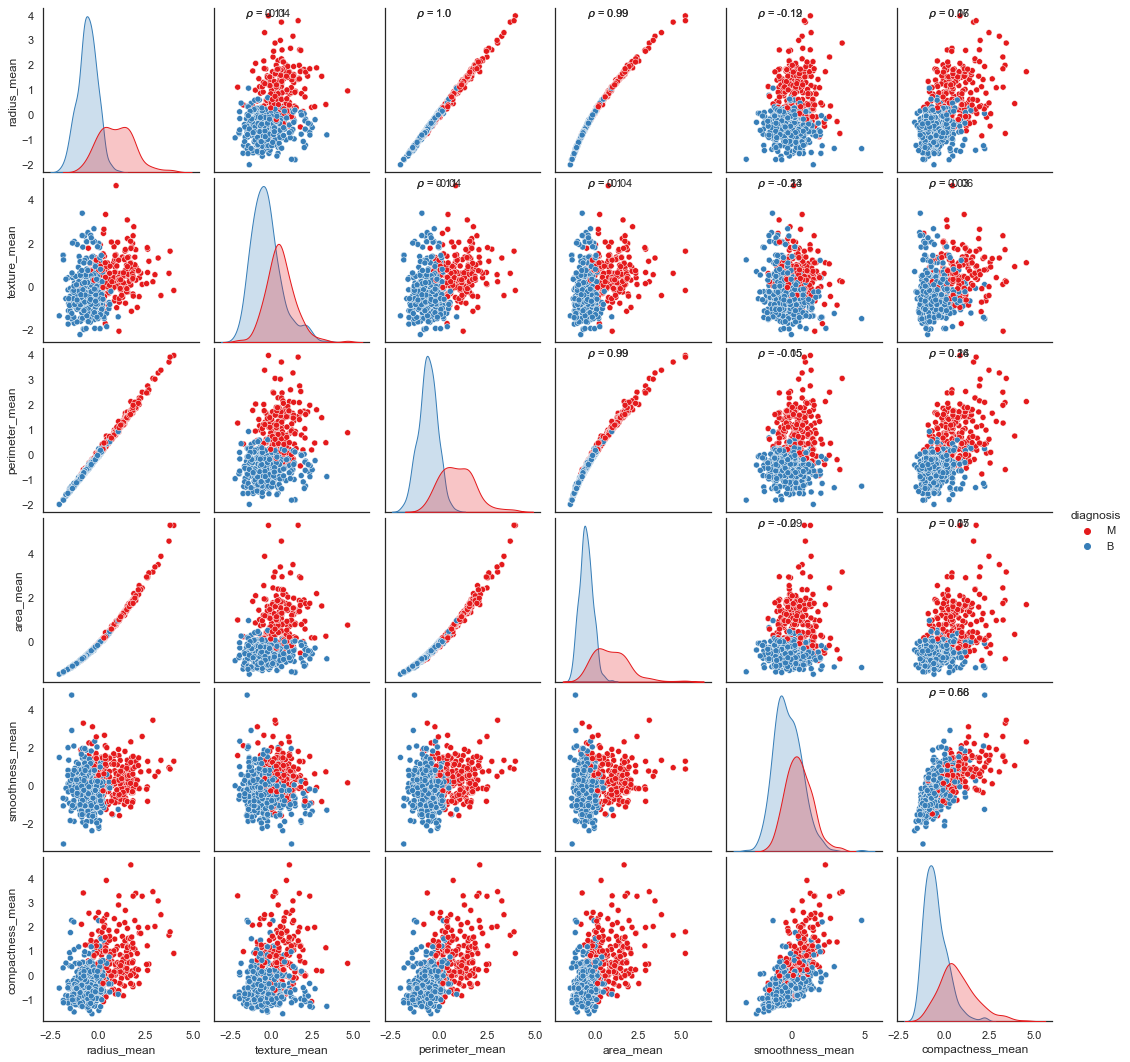

In [19]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 11, xycoords = ax.transAxes)
# First six features
data = pd.concat([y,data_n_2.iloc[:,0:6]],axis=1)
plt.figure(figsize=(10,10))
grid=sns.pairplot(data=data,kind ="scatter",hue="diagnosis",palette="Set1")
grid = grid.map_upper(corr)

<b>Pairplot for next six features (7-12).</b>

<Figure size 720x720 with 0 Axes>

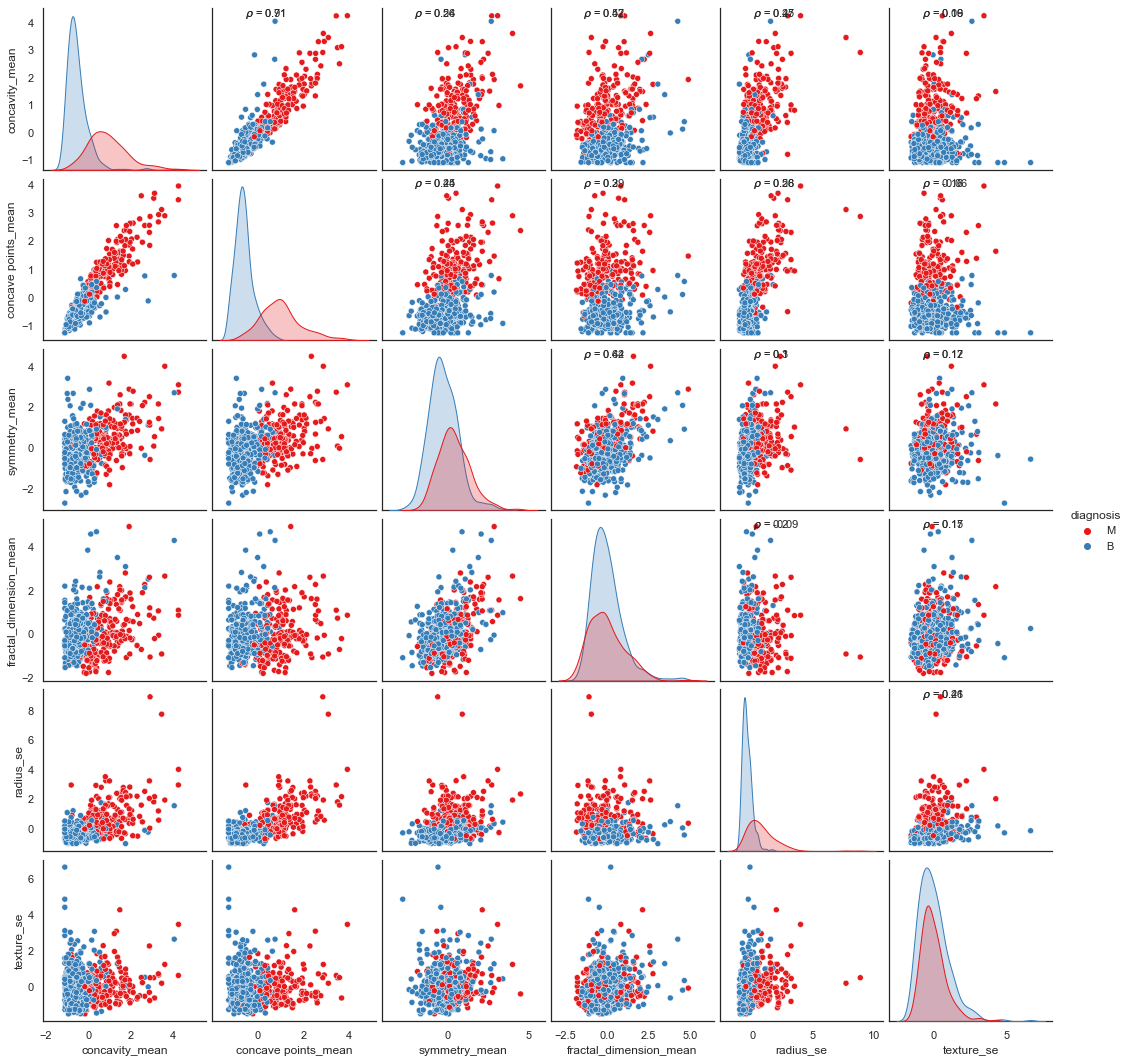

In [20]:
data = pd.concat([y,data_n_2.iloc[:,6:12]],axis=1)
plt.figure(figsize=(10,10))
grid=sns.pairplot(data=data,kind ="scatter",hue="diagnosis",palette="Set1")
grid = grid.map_upper(corr)


<b>Pairplot for next six features (12-18).</b>

<Figure size 720x720 with 0 Axes>

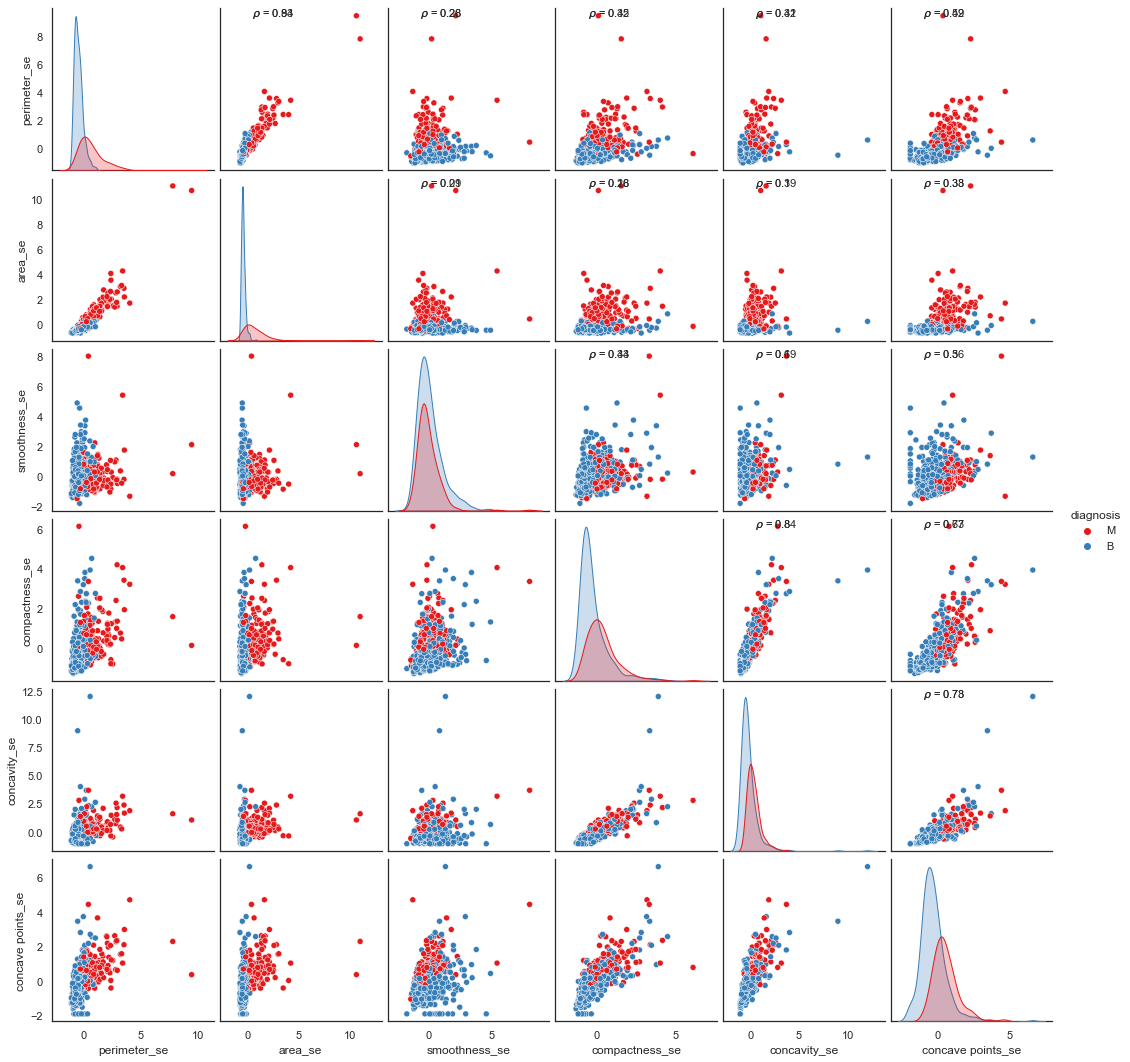

In [21]:
data = pd.concat([y,data_n_2.iloc[:,12:18]],axis=1)
plt.figure(figsize=(10,10))
grid=sns.pairplot(data=data,kind ="scatter",hue="diagnosis",palette="Set1")
grid = grid.map_upper(corr)

<b>Pairplot for next six features (18-24).</b>

<Figure size 720x720 with 0 Axes>

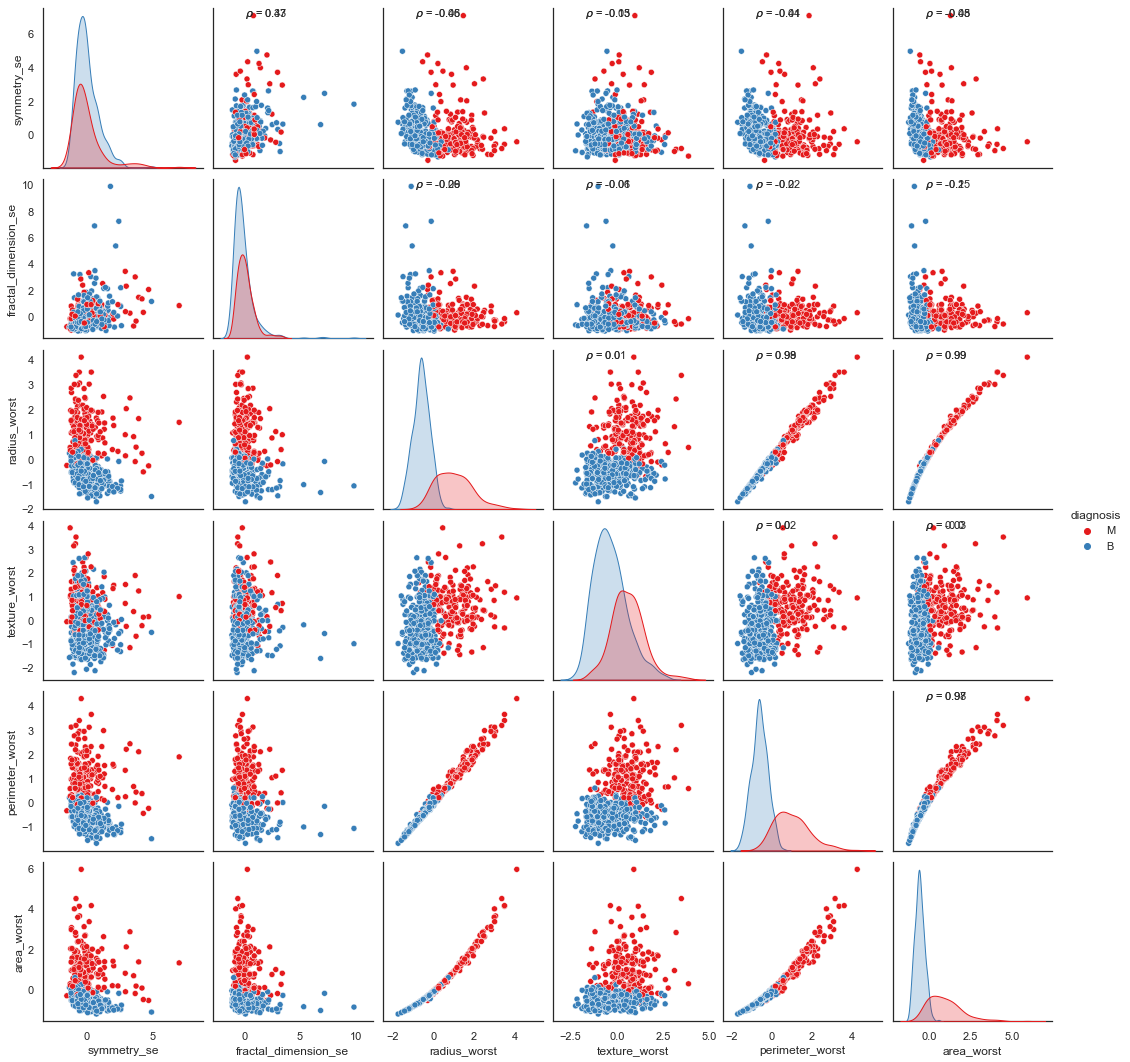

In [22]:
# Next six features
data = pd.concat([y,data_n_2.iloc[:,18:24]],axis=1)
plt.figure(figsize=(10,10))
grid=sns.pairplot(data=data,kind ="scatter",hue="diagnosis",palette="Set1")
grid = grid.map_upper(corr)

<b>Pairplot for next six features (24-30).</b>

<Figure size 720x720 with 0 Axes>

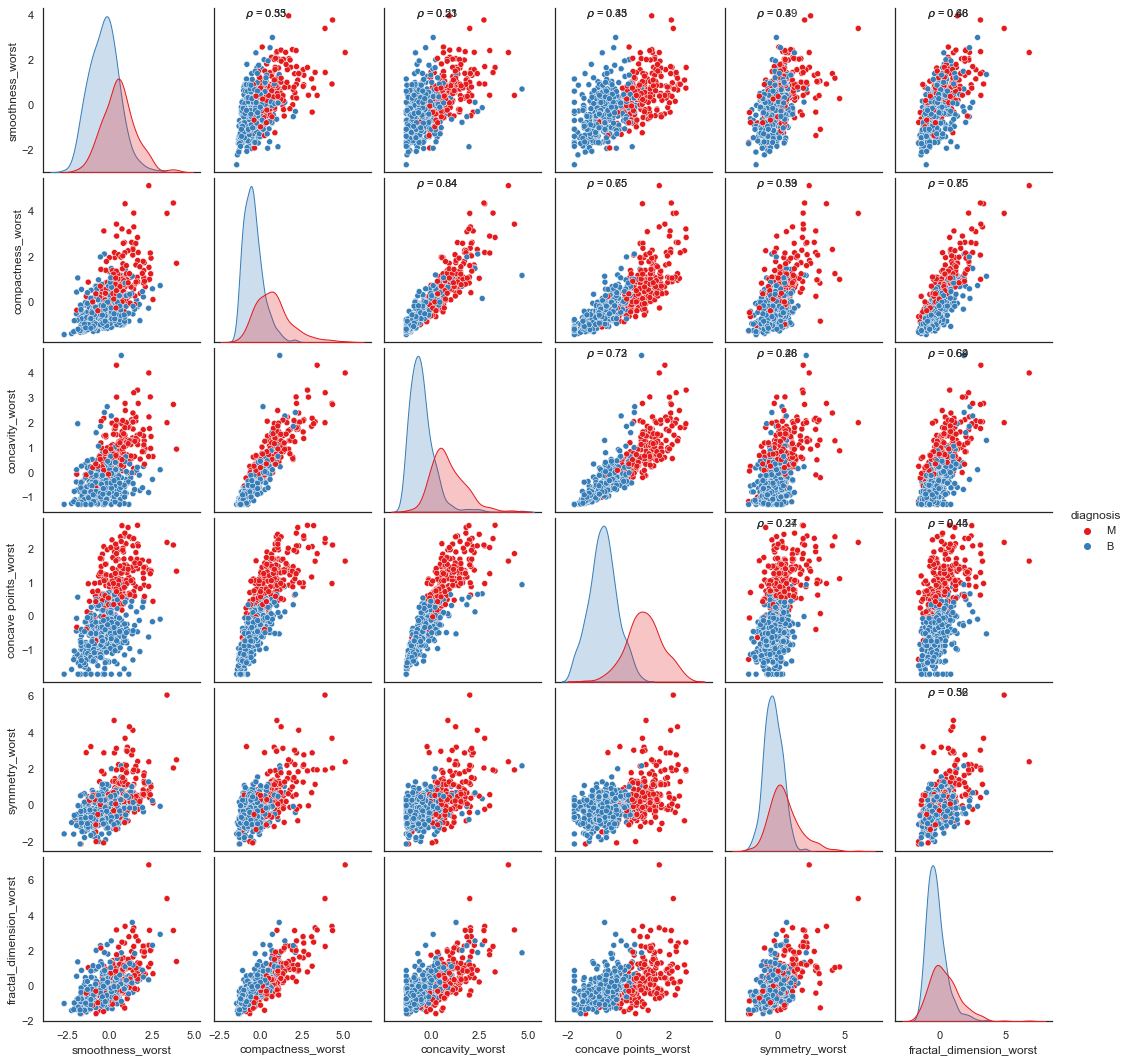

In [23]:
# Next six features
data = pd.concat([y,data_n_2.iloc[:,24:30]],axis=1)
plt.figure(figsize=(10,10))
grid=sns.pairplot(data=data,kind ="scatter",hue="diagnosis",palette="Set1")
grid = grid.map_upper(corr)

A heatmap (or heat map) is a graphical representation of data where values are depicted by color. Here we will generate the heatmap of correlation matrix of continuous features. 

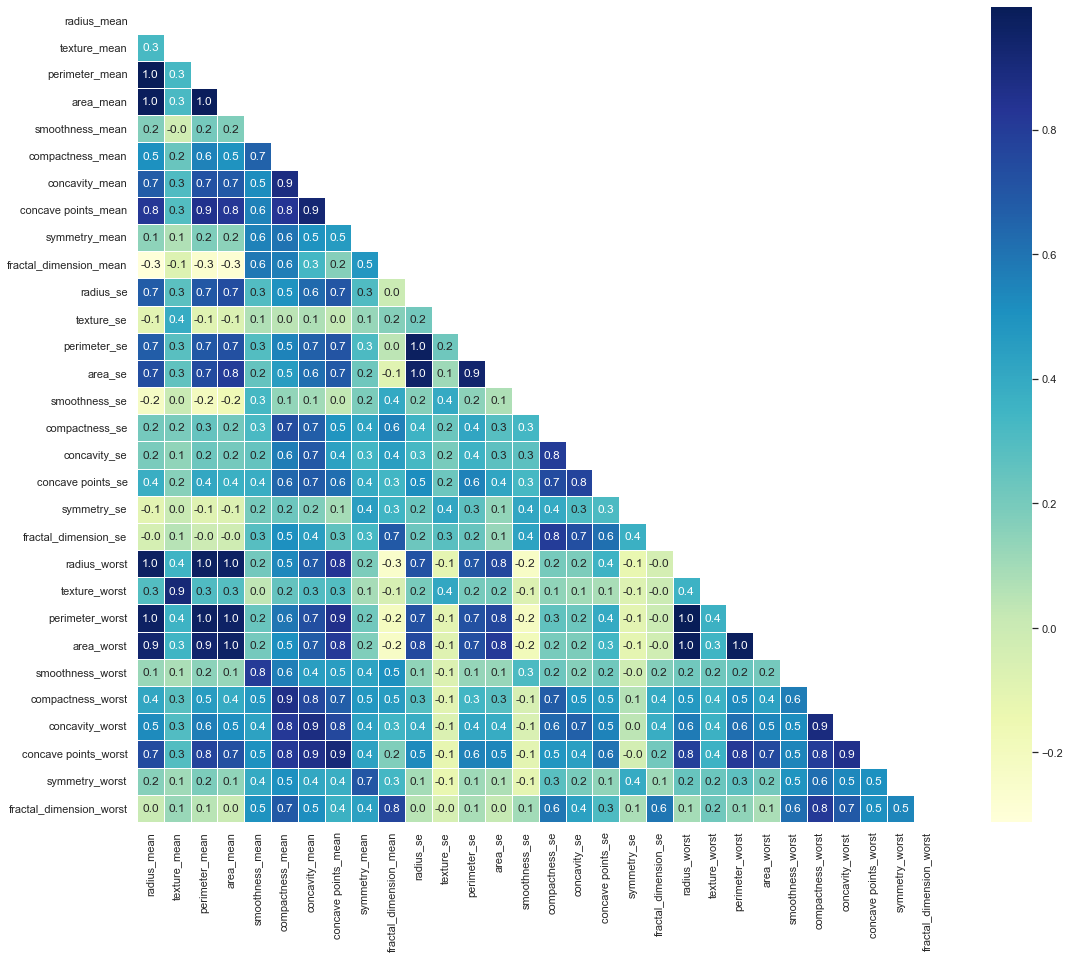

In [24]:
#correlation matrix
corrmat = X.corr()
matrix = np.triu(corrmat)
f, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corrmat, annot=True, linewidths=.5, fmt= '.1f', ax=ax, cmap="YlGnBu", mask=matrix);

As it can be seen in heat map plot <b>radius_mean, perimeter_mean and area_mean</b> are highly correlated with each other so we can use one of them. If you ask how we choose one as a feature to use, well actually there is no correct answer. 

Compactness_mean, concavity_mean and concave points_mean are correlated with each other. Therefore we can choose one of them. Apart from these, radius_se, perimeter_se and area_se are correlated and we can use one of them. radius_worst, perimeter_worst and area_worst are correlated so we can use one of them. Compactness_worst, concavity_worst and concave points_worst so we can use one of them. Compactness_se, concavity_se and concave points_se so we can use one them. texture_mean and texture_worst are correlated and we can use one of them. area_worst and area_mean are correlated, we can use one of them.


<b>Lets drop correlated variables and check again heat map.</b>

In [25]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave points_worst','compactness_se','concave points_se','texture_worst','area_worst']
x_1 = X.drop(drop_list1,axis = 1 ) 

<AxesSubplot:>

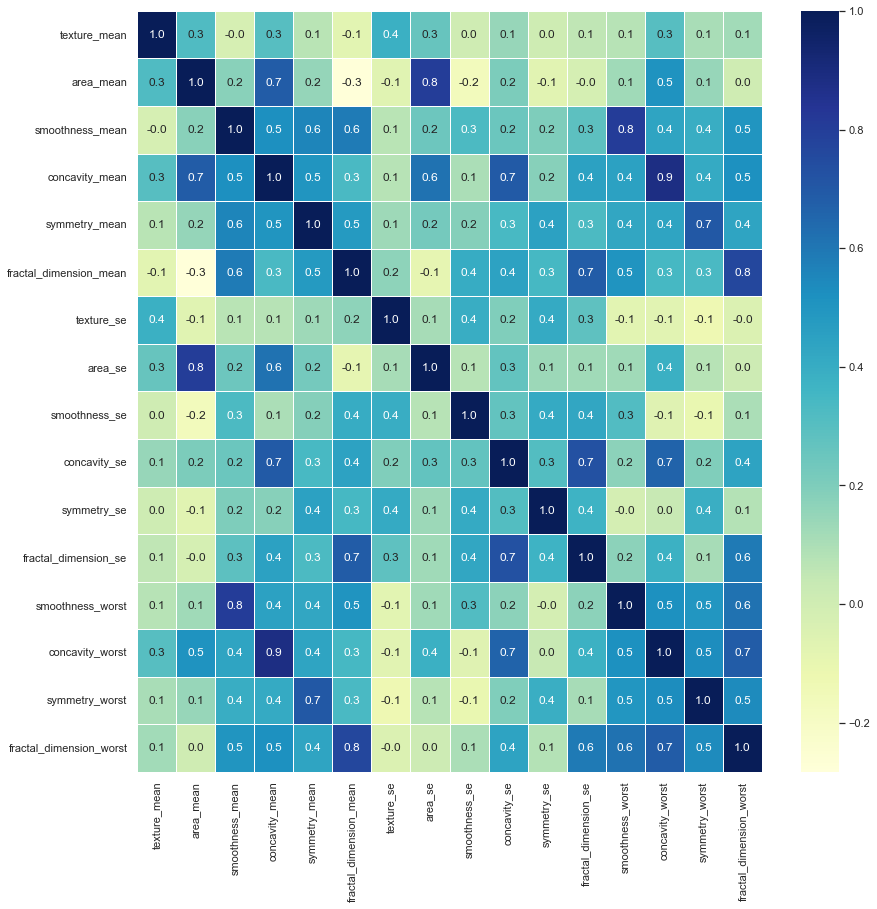

In [26]:
#correlation map
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(x_1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="YlGnBu")

After drop correlated features, as it can be seen in above correlation matrix, there is only one high correlation value 0.9 between concavity_mean and concavity_worst. We will check model performance based on these features in Part 2.

We can conclude that:
* Joint plot, pair plot, and heatmap can be used to see the correlation between variables.
* There are <b>high correlation variables in the dataset.

Now after this analysis, we are ready to do feature selection, modeling and evaluation!